## use Clip-VIT-Base-16

## load data

In [ ]:
from busi_dataset import collect_busi_image_paths, BUSIDataset
from transformers import ViTModel, ViTFeatureExtractor
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

image_paths, labels, mask_paths = collect_busi_image_paths()

print(f"Total images found: {len(image_paths)}")

Total images found: 780


In [ ]:
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')

def vit_transform(image):
    inputs = feature_extractor(images=image, return_tensors='pt')
    return inputs['pixel_values'].squeeze(0)

dataset = BUSIDataset(image_paths, labels, transform=vit_transform)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

d:\soft\anaconda3\envs\clip\lib\site-packages\transformers\models\vit\feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [ ]:
## load model

In [10]:
model = ViTModel.from_pretrained(
    'google/vit-base-patch16-224-in21k',
    attn_implementation="eager"
)

print("ViT original layers:", len(model.encoder.layer))
model.encoder.layer = model.encoder.layer[:8]
print("ViT after pruning:", len(model.encoder.layer))

class ViTClassifier(nn.Module):
    def __init__(self, vit, num_classes):
        super().__init__()
        self.vit = vit
        self.classifier = nn.Linear(vit.config.hidden_size, num_classes)
    def forward(self, x):
        outputs = self.vit(x)
        return self.classifier(outputs.last_hidden_state[:, 0]), outputs

clf_model = ViTClassifier(model, num_classes=3)
clf_model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
clf_model.to(device)

ViT original layers: 12
ViT after pruning: 8


ViTClassifier(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-7): 8 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_featur

Predicted: [1 2 1 1 1 1 2 2]
Ground Truth: [0 0 2 0 1 0 1 0]


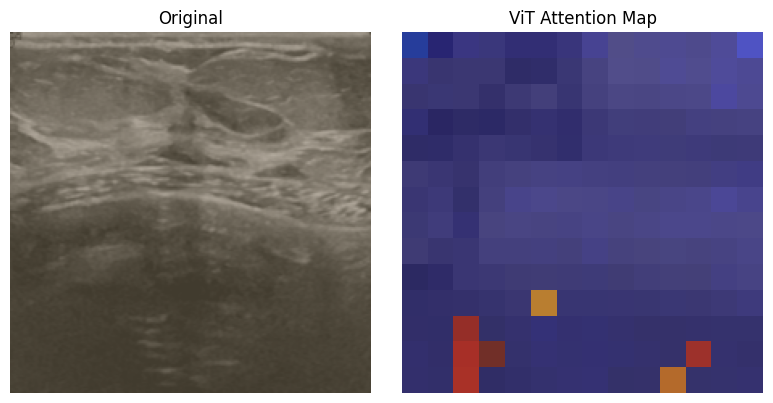

In [ ]:
# Get sample batch and test model
with torch.no_grad():
    for images, targets in dataloader:
        images = images.to(device)
        preds, vit_outputs = clf_model(images)
        pred_classes = torch.argmax(preds, dim=1)
        print("Predicted:", pred_classes.cpu().numpy())
        print("Ground Truth:", targets.numpy())
        sample_img_tensor = images[0].cpu()
        break

with torch.no_grad():
    outputs = clf_model.vit(sample_img_tensor.unsqueeze(0).to(device), output_attentions=True)
    attentions = outputs.attentions

last_attn = attentions[-1][0]  
mean_attn = last_attn.mean(0)[0, 1:]
num_patches = mean_attn.size(0)
grid_size = int(np.sqrt(num_patches))
attn_map = mean_attn.reshape(grid_size, grid_size).cpu().numpy()
attn_map = (attn_map - attn_map.min()) / (attn_map.max() - attn_map.min())

def decode_vit_tensor(pixel_tensor):
    """
    Converts a normalized ViT input tensor [3, 224, 224] to a displayable PIL image.
    Expects normalization: mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
    """
    x = pixel_tensor.numpy()
    mean = np.array([0.485, 0.456, 0.406]).reshape(3, 1, 1)
    std = np.array([0.229, 0.224, 0.225]).reshape(3, 1, 1)
    x = (x * std) + mean
    x = (x * 255).clip(0,255).astype('uint8')
    x = np.transpose(x, (1, 2, 0))
    return Image.fromarray(x)

sample_img_pil = decode_vit_tensor(sample_img_tensor)

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.imshow(sample_img_pil)
plt.title("Original")
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(sample_img_pil)
plt.imshow(attn_map, cmap='jet', alpha=0.5)
plt.title("ViT Attention Map")
plt.axis('off')
plt.tight_layout()
plt.show()

In [13]:
from busi_dataset import collect_busi_image_paths, BUSIDataset
from transformers import ViTModel, ViTFeatureExtractor
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Collect paths ---
image_paths, labels, mask_paths = collect_busi_image_paths()
print(f"Found {len(image_paths)} images.")

# --- Split dataset ---
train_img, val_img, train_lbl, val_lbl = train_test_split(
    image_paths, labels, test_size=0.2, stratify=labels, random_state=42
)
print(f"Train: {len(train_img)} | Val: {len(val_img)}")

Found 780 images.
Train: 624 | Val: 156


In [14]:
# --- ViT transform ---
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')
def vit_transform(image):
    inputs = feature_extractor(images=image, return_tensors='pt')
    return inputs['pixel_values'].squeeze(0)

# --- PyTorch datasets & loaders ---
train_set = BUSIDataset(train_img, train_lbl, transform=vit_transform)
val_set = BUSIDataset(val_img, val_lbl, transform=vit_transform)
train_loader = DataLoader(train_set, batch_size=16, shuffle=True)
val_loader = DataLoader(val_set, batch_size=16, shuffle=False)

d:\soft\anaconda3\envs\clip\lib\site-packages\transformers\models\vit\feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [ ]:
model_full = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k', attn_implementation='eager')

import copy
model_pruned = copy.deepcopy(model_full)
model_pruned.encoder.layer = model_pruned.encoder.layer[:8]

print("Full model layers:", len(model_full.encoder.layer))
print("Pruned model layers:", len(model_pruned.encoder.layer))

Full model layers: 12
Pruned model layers: 8


In [18]:
class ViTClassifier(nn.Module):
    def __init__(self, vit, num_classes):
        super().__init__()
        self.vit = vit
        self.classifier = nn.Linear(vit.config.hidden_size, num_classes)
    def forward(self, x):
        outputs = self.vit(x)
        return self.classifier(outputs.last_hidden_state[:, 0]), outputs

clf_full = ViTClassifier(model_full, num_classes=3).to(device)
clf_pruned = ViTClassifier(model_pruned, num_classes=3).to(device)

In [ ]:
num_epochs = 5
criterion = nn.CrossEntropyLoss()

def train_model(clf_model, train_loader, val_loader, num_epochs=5, lr=1e-4):
    optimizer = optim.Adam(clf_model.parameters(), lr=lr)
    for epoch in range(num_epochs):
        clf_model.train()
        loss_sum, correct, total = 0, 0, 0
        for images, targets in train_loader:
            images, targets = images.to(device), targets.to(device)
            optimizer.zero_grad()
            logits, _ = clf_model(images)
            loss = criterion(logits, targets)
            loss.backward()
            optimizer.step()
            loss_sum += loss.item()
            pred = torch.argmax(logits, dim=1)
            correct += (pred == targets).sum().item()
            total += targets.size(0)
        train_acc = correct / total
        avg_loss = loss_sum / len(train_loader)
        # Validation
        clf_model.eval()
        val_correct, val_total = 0, 0
        with torch.no_grad():
            for images, targets in val_loader:
                images, targets = images.to(device), targets.to(device)
                logits, _ = clf_model(images)
                preds = torch.argmax(logits, dim=1)
                val_correct += (preds == targets).sum().item()
                val_total += targets.size(0)
        val_acc = val_correct / val_total
        print(f"Epoch {epoch+1}/{num_epochs} | TrainLoss: {avg_loss:.4f} | TrainAcc: {train_acc:.4f} | ValAcc: {val_acc:.4f}")
    clf_model.eval()
    return clf_model

# Train full
print("Training FULL model (no pruning):")
clf_full = train_model(clf_full, train_loader, val_loader, num_epochs=5, lr=1e-4)
# Train pruned
print("\nTraining PRUNED model:")
clf_pruned = train_model(clf_pruned, train_loader, val_loader, num_epochs=5, lr=1e-4)

# Train full
print("Training FULL model (no pruning):")
clf_full = train_model(clf_full, train_loader, val_loader, num_epochs=5, lr=1e-4)

# Train pruned
print("\nTraining PRUNED model:")
clf_pruned = train_model(clf_pruned, train_loader, val_loader, num_epochs=5, lr=1e-4)

# --- Save both models ---
import os

save_dir = "saved_models"
os.makedirs(save_dir, exist_ok=True)

# Save full model
full_path = os.path.join(save_dir, "vit_full_classifier.pth")
torch.save(clf_full.state_dict(), full_path)
print(f"Full model saved to: {full_path}")

# Save pruned model
pruned_path = os.path.join(save_dir, "vit_pruned_classifier.pth")
torch.save(clf_pruned.state_dict(), pruned_path)
print(f"Pruned model saved to: {pruned_path}")











  

Training FULL model (no pruning):
Epoch 1/5 | TrainLoss: 0.6932 | TrainAcc: 0.7019 | ValAcc: 0.8590
Epoch 2/5 | TrainLoss: 0.3815 | TrainAcc: 0.8830 | ValAcc: 0.8141
Epoch 3/5 | TrainLoss: 0.2282 | TrainAcc: 0.9263 | ValAcc: 0.8846
Epoch 4/5 | TrainLoss: 0.1199 | TrainAcc: 0.9712 | ValAcc: 0.8397
Epoch 5/5 | TrainLoss: 0.0871 | TrainAcc: 0.9840 | ValAcc: 0.8782

Training PRUNED model:
Epoch 1/5 | TrainLoss: 0.7878 | TrainAcc: 0.6731 | ValAcc: 0.8205
Epoch 2/5 | TrainLoss: 0.3915 | TrainAcc: 0.8766 | ValAcc: 0.8782
Epoch 3/5 | TrainLoss: 0.2245 | TrainAcc: 0.9247 | ValAcc: 0.8718
Epoch 4/5 | TrainLoss: 0.1139 | TrainAcc: 0.9696 | ValAcc: 0.8846
Epoch 5/5 | TrainLoss: 0.0774 | TrainAcc: 0.9840 | ValAcc: 0.8654
Training FULL model (no pruning):
Epoch 1/5 | TrainLoss: 0.0829 | TrainAcc: 0.9760 | ValAcc: 0.8974
Epoch 2/5 | TrainLoss: 0.0731 | TrainAcc: 0.9824 | ValAcc: 0.8462
Epoch 3/5 | TrainLoss: 0.0654 | TrainAcc: 0.9824 | ValAcc: 0.8269
Epoch 4/5 | TrainLoss: 0.0563 | TrainAcc: 0.9792 |

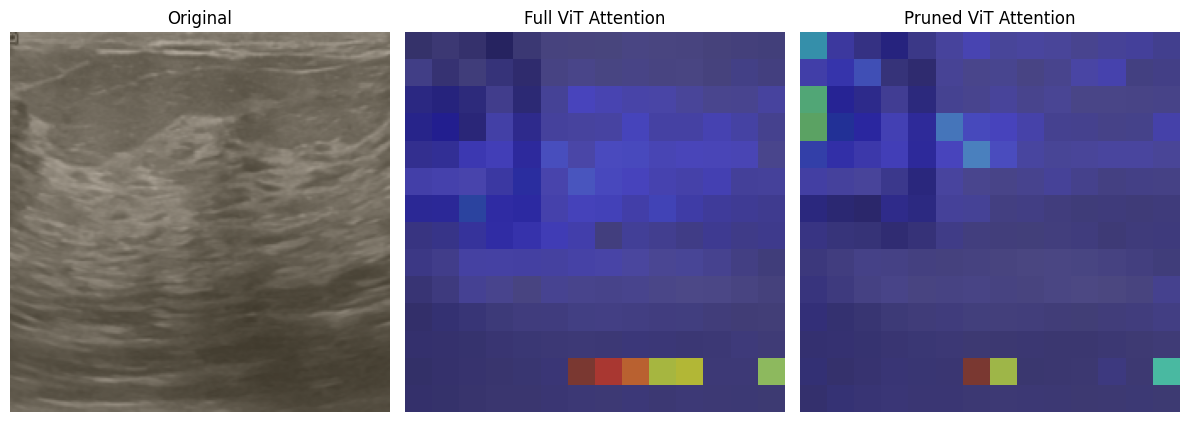

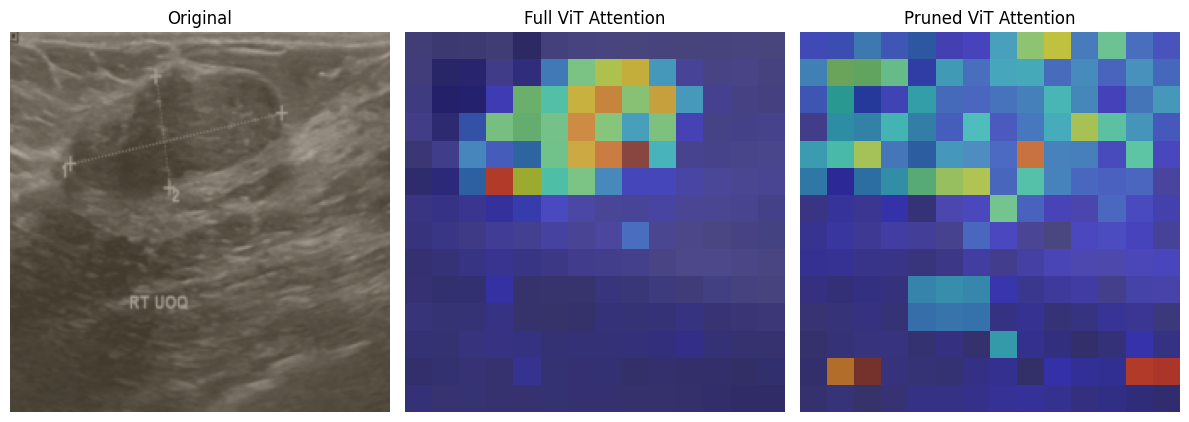

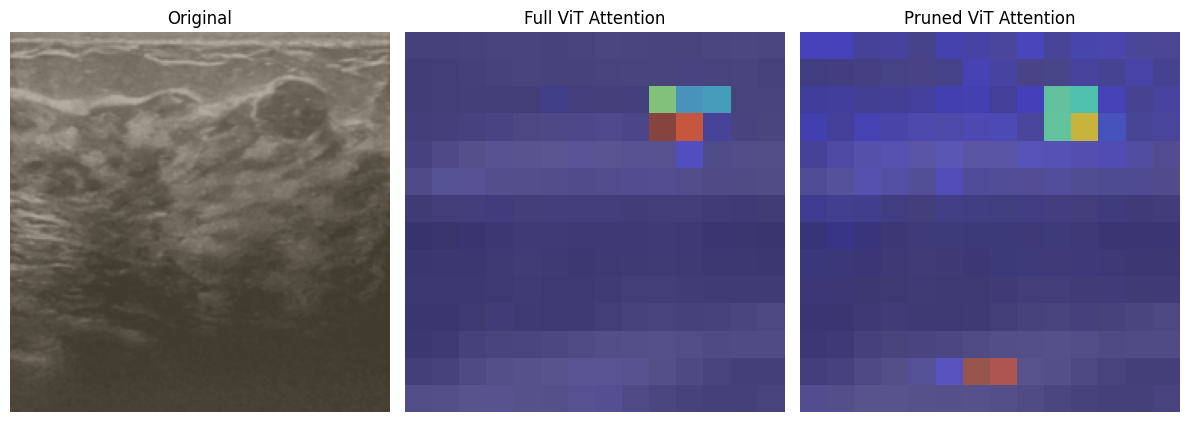

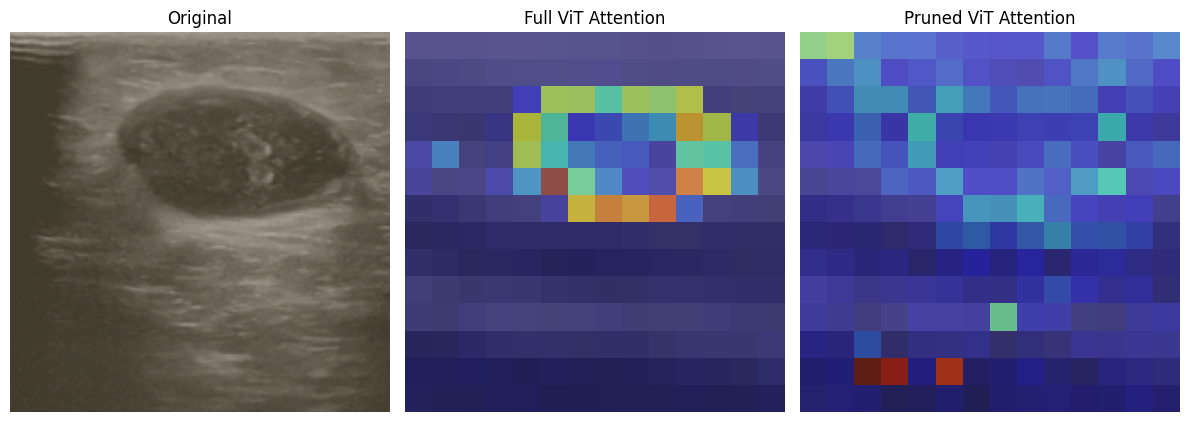

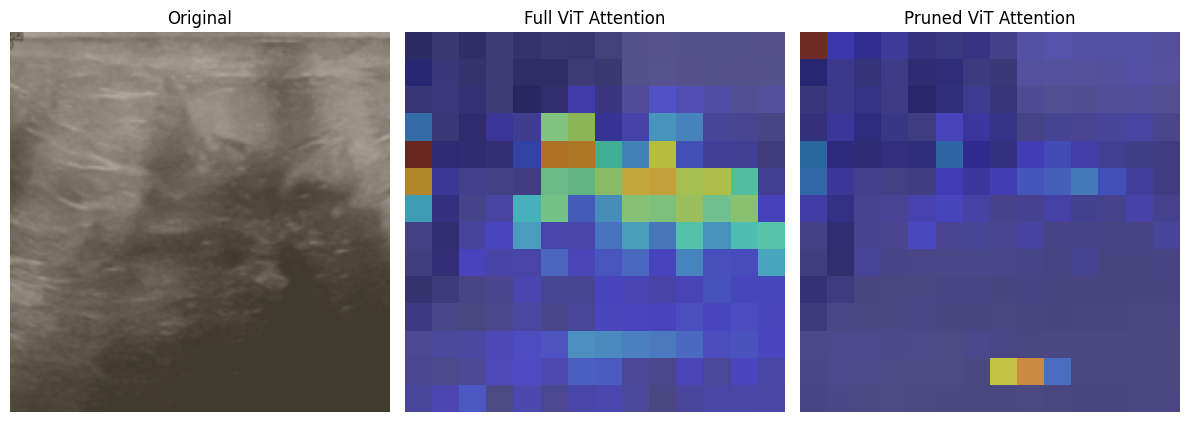

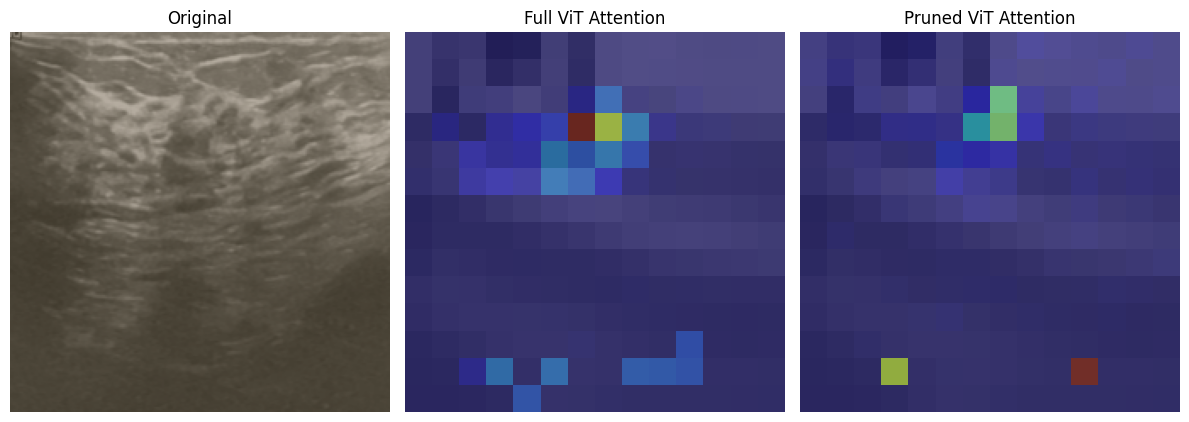

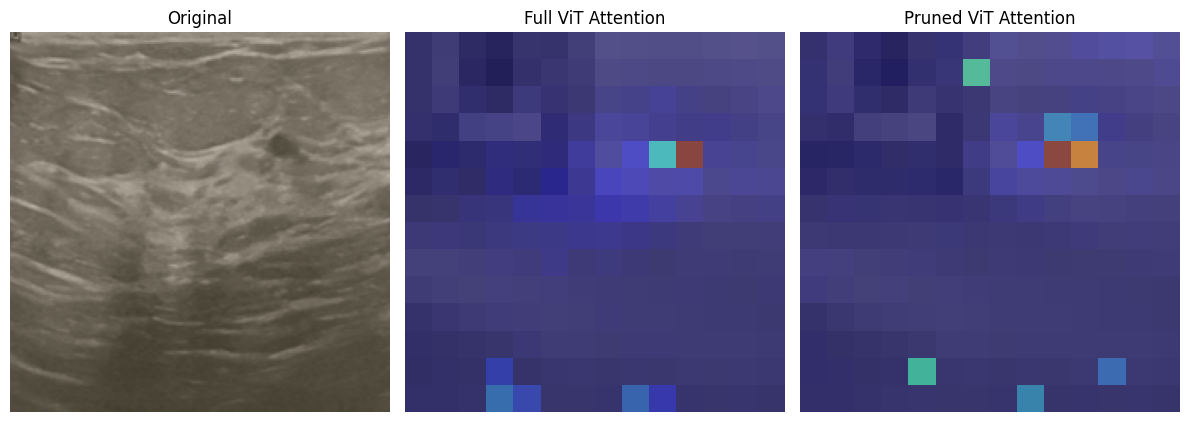

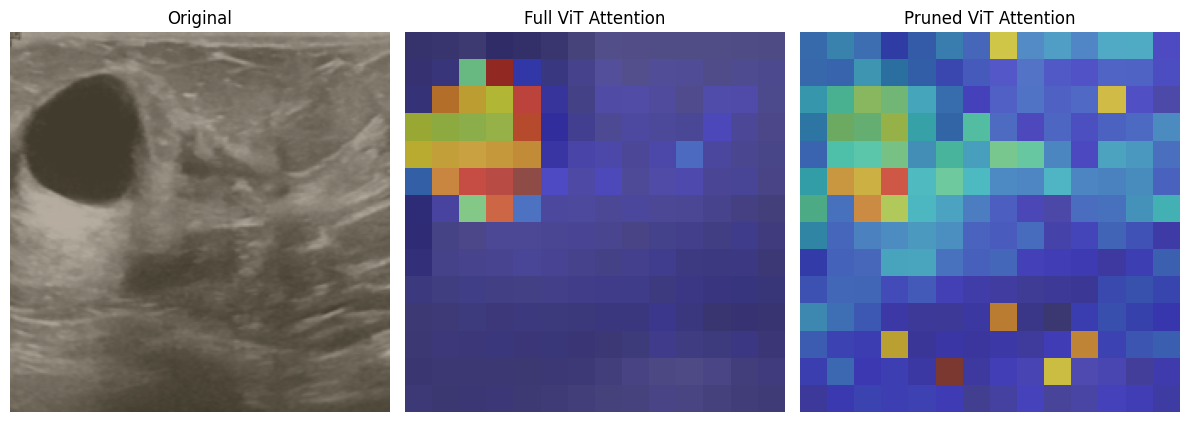

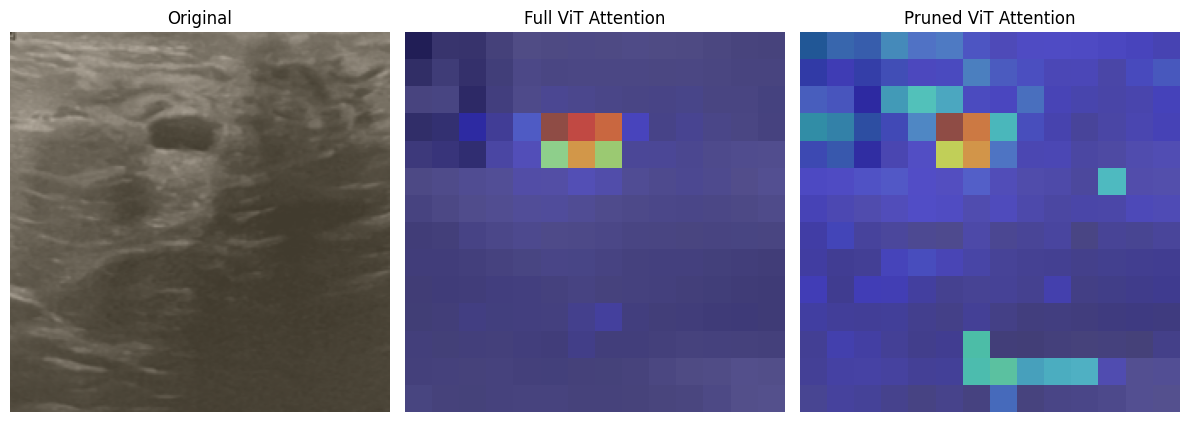

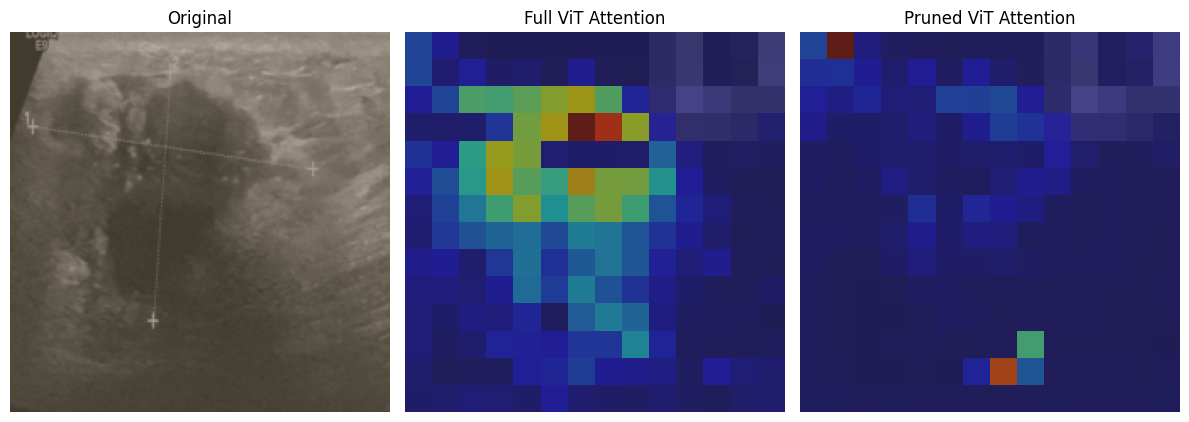

In [ ]:
def show_attention(model, tensor_img, title="ViT Attention Map"):
    with torch.no_grad():
        outputs = model.vit(tensor_img.unsqueeze(0).to(device), output_attentions=True)
        attentions = outputs.attentions
    last_attn = attentions[-1][0] 
    mean_attn = last_attn.mean(0)[0, 1:]
    num_patches = mean_attn.size(0)
    grid_size = int(np.sqrt(num_patches))
    attn_map = mean_attn.reshape(grid_size, grid_size).cpu().numpy()
    attn_map = (attn_map - attn_map.min()) / (attn_map.max() - attn_map.min())
    return attn_map

for i in range(10):
    sample_img_tensor, sample_label = val_set[i]

    def decode_vit_tensor(pixel_tensor):
        x = pixel_tensor.numpy()
        mean = np.array([0.485, 0.456, 0.406]).reshape(3, 1, 1)
        std = np.array([0.229, 0.224, 0.225]).reshape(3, 1, 1)
        x = (x * std) + mean
        x = (x * 255).clip(0,255).astype('uint8')
        x = np.transpose(x, (1,2,0))
        return Image.fromarray(x)

    img_pil = decode_vit_tensor(sample_img_tensor)
    attn_full = show_attention(clf_full, sample_img_tensor, title="Full ViT Attention")
    attn_pruned = show_attention(clf_pruned, sample_img_tensor, title="Pruned ViT Attention")

    plt.figure(figsize=(12,6))
    plt.subplot(1,3,1)
    plt.imshow(img_pil)
    plt.title("Original")
    plt.axis('off')

    plt.subplot(1,3,2)
    plt.imshow(img_pil)
    plt.imshow(attn_full, cmap="jet", alpha=0.5)
    plt.title("Full ViT Attention")
    plt.axis('off')

    plt.subplot(1,3,3)
    plt.imshow(img_pil)
    plt.imshow(attn_pruned, cmap="jet", alpha=0.5)
    plt.title("Pruned ViT Attention")
    plt.axis('off')
    plt.tight_layout()
    plt.show()